In [1]:
import os

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn_pandas import DataFrameMapper

from sklearn.pipeline import Pipeline
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline 
from sklearn2pmml.decoration import ContinuousDomain

from sklearn.datasets import load_iris
from feature_selector import FeatureSelector

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn
import onnxruntime as rt 
from onnx.tools.net_drawer import GetPydotGraph,GetOpNodeProducer 
from onnxmltools.convert.common.shape_calculator import calculate_linear_classifier_output_shapes
#from skl2onnx.operator_converters.RandomForest import convert_sklearn_random_forest_classifier

In [2]:
df=pd.read_csv('data_public.csv.gz',compression='gzip',header=0,sep=',',quotechar='"',na_values='?')
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,2
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,3
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,2
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 16 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   A       1200000 non-null  float64
 1   B       1200000 non-null  float64
 2   C       1200000 non-null  float64
 3   D       1200000 non-null  float64
 4   E       1200000 non-null  float64
 5   F       1200000 non-null  float64
 6   G       1200000 non-null  float64
 7   H       1200000 non-null  float64
 8   I       1200000 non-null  float64
 9   J       1200000 non-null  float64
 10  K       1200000 non-null  float64
 11  L       1200000 non-null  float64
 12  M       1200000 non-null  float64
 13  N       1200000 non-null  float64
 14  O       1200000 non-null  float64
 15  Class   1200000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 146.5 MB


In [5]:
# labels=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O']
# X=pd.DataFrame(data=df.drop('Class',axis=1),columns=labels)
# Y=pd.DataFrame(data=df['Class'],columns=['Class'])
# X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3)
# training_data=pd.concat([X_train,Y_train],axis=1)
# training_data.head()

columns = list(df.columns[:15])
X = df[columns]
y = pd.DataFrame(data=df['Class'],columns=['Class'])
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(960000, 15) (960000, 1)
(240000, 15) (240000, 1)


In [7]:
training_data = pd.concat([X_train, y_train], axis=1)
training_data

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
310157,-32.378681,-10.298088,9.701485,18.953906,-25.380718,-25.405962,-0.666111,-25.247311,-8.295343,24.478557,0.769897,9.403057,-59.225366,-3.986116,-3.164566,3
839462,-38.934519,-17.971962,10.586501,22.666934,-21.945633,-30.428085,0.028243,-25.646947,-7.830545,23.050000,3.997929,2.804476,-54.080977,-5.079206,2.743360,2
922317,-35.149266,-12.263531,13.575841,21.033731,-25.170953,-25.016780,-0.537504,-22.042470,-6.746907,30.029223,4.532048,5.358930,-53.226449,-10.805857,1.153727,2
1015997,228.903316,-5.683945,216.597525,-14.024142,130.861955,85.334420,115.549702,190.864327,83.930390,130.215659,208.414672,-12.737473,-13.738288,128.003139,151.597553,2
834718,-40.376219,-8.819774,15.373138,23.710292,-24.085359,-24.195575,1.455817,-24.519218,-4.199648,36.070433,1.086851,-4.249433,-55.118378,-3.447659,1.139057,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977334,232.189848,-12.199876,223.403265,-10.452320,140.565223,79.325989,106.904166,174.679120,80.056555,121.118016,226.897034,2.495844,-25.613904,132.734297,158.411271,2
603905,-33.316416,-12.855104,15.291714,21.091457,-22.520458,-25.490742,1.119288,-21.572028,-7.835686,29.676339,3.562139,4.318607,-59.352319,-6.442074,-1.283640,2
707716,-34.300723,-13.344278,5.646639,13.736454,-27.225849,-27.407595,6.466654,-23.328714,-8.912388,18.826633,4.395824,5.154872,-54.374638,-11.321316,1.543809,3
270869,-31.372837,-10.051694,14.657061,23.487017,-27.282914,-36.693000,4.999870,-23.484190,-9.651413,25.413762,3.067992,-1.382674,-59.815511,-11.707673,-0.561535,3


In [8]:
testing_data = pd.concat([X_test, y_test], axis=1)
testing_data

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
533737,-33.694031,-8.223007,10.753329,16.969375,-25.725674,-19.787666,-0.481533,-30.662609,-8.836358,23.529264,4.028038,-4.481999,-57.034219,-0.853658,-3.018860,2
267004,-34.094508,-12.983951,4.823302,20.785718,-30.850117,-19.288789,-0.310562,-23.423412,-8.108620,27.087715,3.156982,4.017071,-54.779375,-14.580356,-1.830891,1
550268,-58.233931,-51.432215,-38.101502,-117.589017,-12.872515,-122.022156,-53.419700,-0.489771,49.180191,-95.501383,39.310457,-43.073358,-52.686254,33.215698,60.153038,2
971877,-35.596040,-18.734817,14.738980,17.443033,-29.777020,-24.112640,-0.682228,-20.231809,-9.163517,24.788057,3.297012,7.440163,-54.577145,-5.272082,1.436589,3
62937,-64.379548,-36.650883,-38.796408,-103.098068,-14.794714,-124.246036,-52.418622,1.863464,53.571364,-95.553132,48.566436,-37.756068,-46.797249,40.064298,62.555501,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248307,229.588625,-10.672124,217.093804,-11.232495,135.106160,92.163398,118.795930,215.079965,80.502396,135.467802,217.799981,-6.853388,-11.479073,139.383686,156.159582,1
1137323,228.140015,-8.412261,219.074456,-15.283519,130.330442,90.365114,128.666397,197.776221,83.436425,132.290181,222.727813,-3.772150,-8.824583,132.140212,154.121972,3
943311,-33.176465,-14.494626,7.554070,18.878960,-21.718072,-24.023242,-4.335819,-31.065530,-7.855115,23.395178,-4.683014,0.850930,-50.678787,-6.185869,0.463701,3
589074,-64.197788,-47.913856,-40.463701,-113.547514,-9.014064,-123.099534,-49.398719,-7.118966,52.994090,-89.258989,55.490379,-34.428752,-39.030175,24.717892,67.487759,2


In [9]:
# sc=StandardScaler()
# df_scaled=sc.fit_transform(df.drop('Class',axis=1))
# df_scaled=pd.DataFrame(df_scaled,columns=labels)
# df_scaled=pd.concat([df_scaled,df['Class']],axis=1)
# pca_test=decomposition.PCA(n_components=15)
# pca_test.fit(df_scaled.drop('Class',axis=1))
# plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('explained variance')
# plt.show()
# pca_test.explained_variance_ratio_


temp_df = df[columns]
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(temp_df))
df_scaled = pd.concat([df_scaled,df['Class']],axis=1)
df_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Class
0,1.398333,0.457892,1.386800,-0.043941,1.518831,1.136805,1.499176,1.421937,1.182621,1.123217,1.531100,0.048383,1.542774,1.390885,1.402222,2
1,-0.686316,0.320671,-0.589262,0.764323,-0.755534,-0.166762,-0.477999,-0.820431,-0.980689,-0.222670,-0.792750,0.613532,-0.949550,-0.909245,-0.875843,3
2,-0.695429,-0.109594,-0.480605,0.710940,-0.759987,-0.177913,-0.520931,-0.739075,-0.939343,-0.190270,-0.774695,0.830704,-0.815240,-0.805046,-0.910959,2
3,1.322591,0.902156,1.378256,0.077838,1.336854,1.249231,1.157837,1.416902,1.175193,1.509929,1.408750,0.200674,1.499253,1.274864,1.338920,2
4,1.376193,0.441525,1.263438,0.005832,1.503497,1.331041,1.259054,1.529661,1.350708,1.161552,1.290718,0.332113,1.518267,1.469607,1.313165,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,-0.583934,0.574725,-0.534696,0.657050,-0.781209,-0.347150,-0.519643,-0.691211,-0.987396,-0.157322,-0.816495,0.547687,-0.468207,-0.860710,-0.934167,2
1199996,-0.698200,0.267472,-0.504915,0.675492,-0.770037,-0.251527,-0.475704,-0.708306,-0.986908,-0.136848,-0.922171,0.491340,-0.720338,-0.747363,-0.902058,3
1199997,1.340711,0.101371,1.350786,0.034566,1.344392,1.294568,1.296033,1.439018,1.130041,1.404063,1.299614,0.304915,1.537185,1.487511,1.265098,1
1199998,-0.842045,-1.602949,-1.084858,-2.319727,-0.550122,-1.547680,-1.334400,-0.589197,0.521012,-1.679556,-0.469105,-1.858541,-0.946075,-0.232754,-0.073445,2


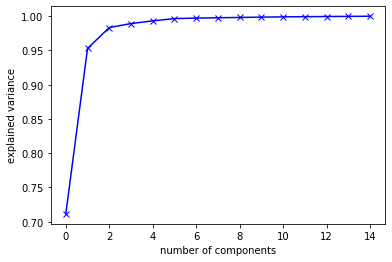

[7.11447169e-01 2.41423046e-01 3.05472040e-02 5.76603629e-03
 3.95249929e-03 3.35997122e-03 6.37710310e-04 5.44675407e-04
 4.57257234e-04 4.47617738e-04 3.71201367e-04 3.01512481e-04
 2.48754417e-04 1.94997777e-04 1.79105275e-04]

 [71.14471689 95.28702154 98.34174195 98.91834558 99.3135955  99.64959263
 99.71336366 99.7678312  99.81355692 99.8583187  99.89543883 99.92559008
 99.95046552 99.9699653  99.98787583]


In [10]:
# Apply PCA on all the components
pca_all_comp = decomposition.PCA(n_components=15)
pca_all_comp.fit(df_scaled)

plt.plot(np.cumsum(pca_all_comp.explained_variance_ratio_),'bx-')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()
print(pca_all_comp.explained_variance_ratio_)
print('\n',np.cumsum(pca_all_comp.explained_variance_ratio_*100))

In [11]:
pca = decomposition.PCA(n_components=0.95)
pca.fit(df_scaled)

print("The optimal number of components to maintain 95% variance : {}".format(pca.n_components_))

The optimal number of components to maintain 95% variance : 2


In [12]:
features='ABCDEFGHIJKLMNO'
for i in range(0,len(features)):
    pipeline=PMMLPipeline([('mapper',DataFrameMapper([(X_train.columns.drop([features[i:i+1]]).values,
                                                       [StandardScaler()])])),
                           ('pca',PCA(n_components=2)),
                           ('classifier',DecisionTreeClassifier(max_depth=3))])
    pipeline.fit(training_data.drop([features[i:i+1]],axis=1),training_data['Class'])
    results=pipeline.predict(X_test)
    actual=np.concatenate(y_test.values)
    print("Dropped feature:",features[i:i+1],", Accuracy:",metrics.accuracy_score(actual,results))

Dropped feature: A , Accuracy: 0.5002541666666667
Dropped feature: B , Accuracy: 0.5002166666666666
Dropped feature: C , Accuracy: 0.50025
Dropped feature: D , Accuracy: 0.5002833333333333
Dropped feature: E , Accuracy: 0.5002625
Dropped feature: F , Accuracy: 0.5002375
Dropped feature: G , Accuracy: 0.50025
Dropped feature: H , Accuracy: 0.50025
Dropped feature: I , Accuracy: 0.5002666666666666
Dropped feature: J , Accuracy: 0.5002583333333334
Dropped feature: K , Accuracy: 0.5002666666666666
Dropped feature: L , Accuracy: 0.5001666666666666
Dropped feature: M , Accuracy: 0.5002375
Dropped feature: N , Accuracy: 0.5002375
Dropped feature: O , Accuracy: 0.5002458333333333


In [13]:
####### No use
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train))
X_train_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.642334,0.590217,-0.587819,0.692939,-0.752452,-0.262660,-0.486274,-0.738206,-0.978879,-0.213462,-0.828561,1.036763,-0.943356,-0.794432,-0.942604
1,-0.693065,0.059680,-0.579411,0.772110,-0.705273,-0.331382,-0.475846,-0.742071,-0.967856,-0.232032,-0.794520,0.613037,-0.656061,-0.810681,-0.854123
2,-0.663773,0.454335,-0.551014,0.737286,-0.749571,-0.257334,-0.484343,-0.707209,-0.942158,-0.141307,-0.788887,0.777071,-0.608338,-0.895808,-0.877930
3,1.379533,0.909217,1.377615,-0.010233,1.393436,1.252705,1.259000,1.352020,1.208221,1.161052,1.361173,-0.384985,1.596933,1.167592,1.375217
4,-0.704221,0.692420,-0.533940,0.794357,-0.734661,-0.246097,-0.454408,-0.731164,-0.881751,-0.062775,-0.825219,0.160072,-0.713996,-0.786428,-0.878150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959995,1.404965,0.458736,1.442267,0.065927,1.526704,1.170486,1.129166,1.195477,1.116354,1.042789,1.556081,0.593219,0.933723,1.237921,1.477264
959996,-0.649590,0.413436,-0.534714,0.738517,-0.713168,-0.263820,-0.459462,-0.702659,-0.967978,-0.145894,-0.799116,0.710267,-0.950446,-0.830940,-0.914434
959997,-0.657207,0.379617,-0.626338,0.581690,-0.777793,-0.290050,-0.379157,-0.719649,-0.993512,-0.286933,-0.790324,0.763967,-0.672461,-0.903470,-0.872088
959998,-0.634550,0.607251,-0.540743,0.789596,-0.778577,-0.417111,-0.401185,-0.721153,-1.011037,-0.201305,-0.804327,0.344161,-0.976314,-0.909214,-0.903619


In [14]:
print("Correlation Matrix")
df.corr('pearson')

Correlation Matrix


,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
A,1.000000,0.455949,0.991999,0.071330,0.990703,0.905353,0.972223,0.988807,0.818399,0.870016,0.968827,0.139619,0.958931,0.953081,0.920322,-0.000620
B,0.455949,1.000000,0.541742,0.865856,0.352946,0.760708,0.620607,0.339549,-0.098558,0.803246,0.246429,0.854635,0.345030,0.194578,0.098805,0.000138
C,0.991999,0.541742,1.000000,0.176224,0.971805,0.943482,0.988351,0.968342,0.753474,0.915784,0.937868,0.238723,0.941040,0.916578,0.873800,-0.000686
D,0.071330,0.865856,0.176224,1.000000,-0.047459,0.477183,0.279248,-0.062451,-0.502643,0.544357,-0.163679,0.949485,-0.042057,-0.217856,-0.316241,0.000150
E,0.990703,0.352946,0.971805,-0.047459,1.000000,0.849129,0.939705,0.997116,0.879142,0.805749,0.989217,0.026319,0.964769,0.979925,0.958885,-0.000649
F,0.905353,0.760708,0.943482,0.477183,0.849129,1.000000,0.969055,0.841227,0.508345,0.989868,0.781534,0.518117,0.823551,0.745156,0.675416,-0.000540
G,0.972223,0.620607,0.988351,0.279248,0.939705,0.969055,1.000000,0.934714,0.678043,0.949429,0.894114,0.335039,0.910385,0.867546,0.815281,-0.000472
H,0.988807,0.339549,0.968342,-0.062451,0.997116,0.841227,0.934714,1.000000,0.886017,0.796856,0.990875,0.012005,0.964627,0.982403,0.962873,-0.000670
I,0.818399,-0.098558,0.753474,-0.502643,0.879142,0.508345,0.678043,0.886017,1.000000,0.439881,0.926217,-0.418110,0.848801,0.943365,0.970965,-0.000766
J,0.870016,0.803246,0.915784,0.544357,0.805749,0.989868,0.949429,0.796856,0.439881,1.000000,0.730841,0.579309,0.781815,0.691273,0.615931,-0.000333


In [15]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 10))

Top Absolute Correlations
E  H    0.997116
K  N    0.992158
A  C    0.991999
H  K    0.990875
A  E    0.990703
F  J    0.989868
E  K    0.989217
N  O    0.988920
A  H    0.988807
C  G    0.988351
dtype: float64


In [27]:
fs = FeatureSelector(data = training_data.drop('Class',axis=1), labels =training_data['Class'] )
fs.identify_collinear(correlation_threshold = 0.98)

8 features with a correlation magnitude greater than 0.98.



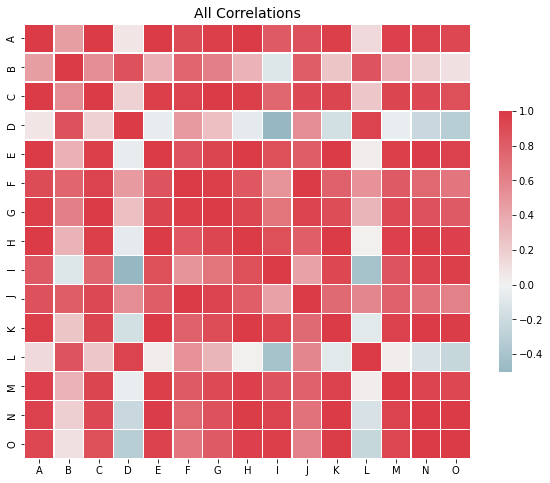

In [28]:
fs.plot_collinear( plot_all = True)

In [39]:
collinear_features = fs.ops['collinear']
fs.record_collinear

,drop_feature,corr_feature,corr_value
0,C,A,0.991993
1,E,A,0.990701
2,G,C,0.988347
3,H,A,0.988804
4,H,E,0.997115
5,J,F,0.989862
6,K,E,0.989207
7,K,H,0.990873
8,N,H,0.982397
9,N,K,0.992164


In [30]:
fs.identify_zero_importance(task = 'classification',
                            eval_metric = 'multi_error',
                            n_iterations = 10,
                            early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.500868	valid_0's multi_logloss: 1.01172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.500868	valid_0's multi_logloss: 1.01172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[4]	valid_0's multi_error: 0.500868	valid_0's multi_logloss: 1.01171
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.500868	valid_0's multi_logloss: 1.01172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.500868	valid_0's multi_logloss: 1.01172
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_error: 0.500868	val

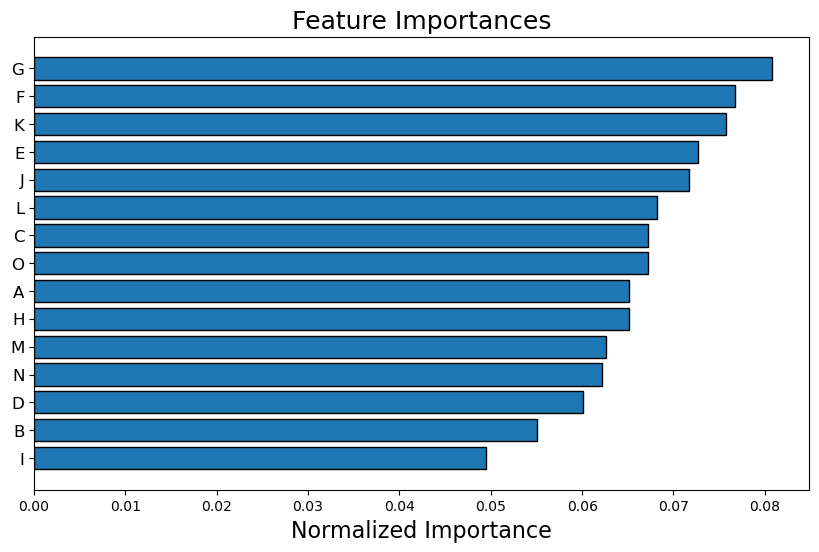

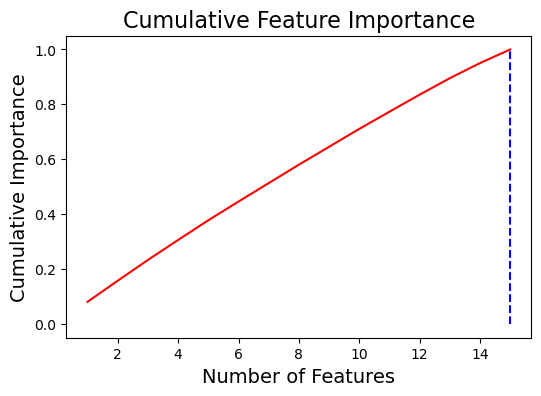

15 features required for 0.97 of cumulative importance


In [32]:
zero_importance_features = fs.ops['zero_importance']
fs.plot_feature_importances(threshold = 0.97, plot_n = 15)

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', KNeighborsClassifier())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', LogisticRegression())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))

results = []
names=[]
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\anaconda3\lib\site-packages\sklearn\u

ScaledLR: 0.499130 (0.001269)


C:\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\anaconda3\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

KeyboardInterrupt: 

In [16]:
to_drop = ['E','H','K','N','A','C']

pipeline0=PMMLPipeline([('mapper',DataFrameMapper([(X_train.columns.drop(to_drop).values,
                                                       [StandardScaler()])])),
                        ('pca',PCA(n_components=2)),
                        ('classifier',DecisionTreeClassifier(max_depth=3))])
pipeline0.fit(training_data.drop(to_drop,axis=1),training_data['Class'])
results=pipeline0.predict(X_test)
actual=np.concatenate(y_test.values)
print('Accuracy:', metrics.accuracy_score(actual,results))

Accuracy: 0.5002458333333333


In [17]:
to_keep = ['A','C','E','F','H','K','N']

pipeline1=PMMLPipeline([('mapper',DataFrameMapper([(X_train[to_keep].columns.values,
                                                       [StandardScaler()])])),
                        ('pca',PCA(n_components=2)),
                        ('classifier',DecisionTreeClassifier(max_depth=3))])
pipeline1.fit(training_data,training_data['Class'])
results=pipeline1.predict(X_test)
actual=np.concatenate(y_test.values)
print('Accuracy:', metrics.accuracy_score(actual,results))

Accuracy: 0.5002625


In [18]:
to_keep = ['C','E','G','H','J','K','N','O']

pipeline2=PMMLPipeline([('mapper',DataFrameMapper([(X_train[to_keep].columns.values,
                                                       [StandardScaler()])])),
                        ('pca',PCA(n_components=2)),
                        ('classifier',DecisionTreeClassifier(max_depth=3))])
pipeline2.fit(training_data,training_data['Class'])
results=pipeline2.predict(X_test)
actual=np.concatenate(y_test.values)
print('Accuracy:', metrics.accuracy_score(actual,results))

Accuracy: 0.5002458333333333


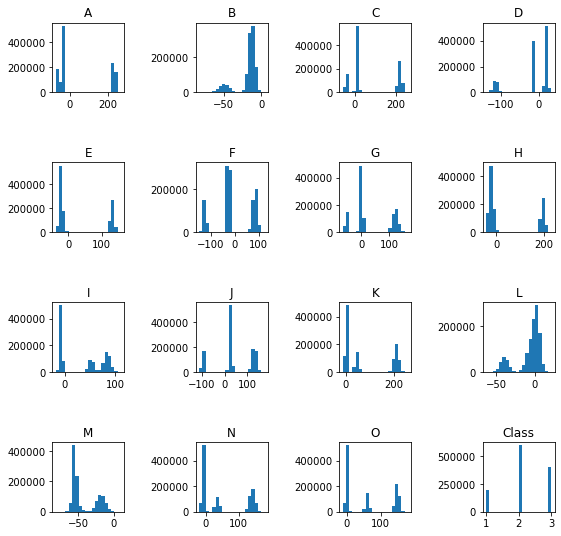

In [19]:
fig1 = plt.figure()
for i in range(1,16):
    fig1.add_subplot(4,4,i)
    plt.hist(df[features[i-1:i]], bins=20)
    plt.title(features[i-1:i])
    
fig1.add_subplot(4,4,16)
plt.hist(df['Class'], bins=20)
plt.title('Class')
fig1.subplots_adjust(hspace=1, wspace=1)
fig1.set_figheight(9)
fig1.set_figwidth(9)

In [20]:
to_keep = ['A','B','D','I','L','M']

pipeline3=PMMLPipeline([('mapper',DataFrameMapper([(X_train[to_keep].columns,
                                                       [StandardScaler()])])),
                        ('pca',PCA(n_components=2)),
                        ('classifier',DecisionTreeClassifier(max_depth=3))])
pipeline3.fit(training_data,training_data['Class'])
results=pipeline3.predict(X_test)
actual=np.concatenate(y_test.values)
print('Accuracy:', metrics.accuracy_score(actual,results))

Accuracy: 0.5002625


In [21]:
to_keep = ['A','B','D','I','L','M']

pipeline4=PMMLPipeline([('mapper',DataFrameMapper([(X_train[to_keep].columns,
                                                       [StandardScaler()])])),
                        ('pca',PCA(n_components=2)),
                        ('classifier',RandomForestClassifier(max_depth=2))])
pipeline4.fit(training_data,training_data['Class'])
results=pipeline4.predict(X_test)
actual=np.concatenate(y_test.values)
print('Accuracy:', metrics.accuracy_score(actual,results))

Accuracy: 0.5002625


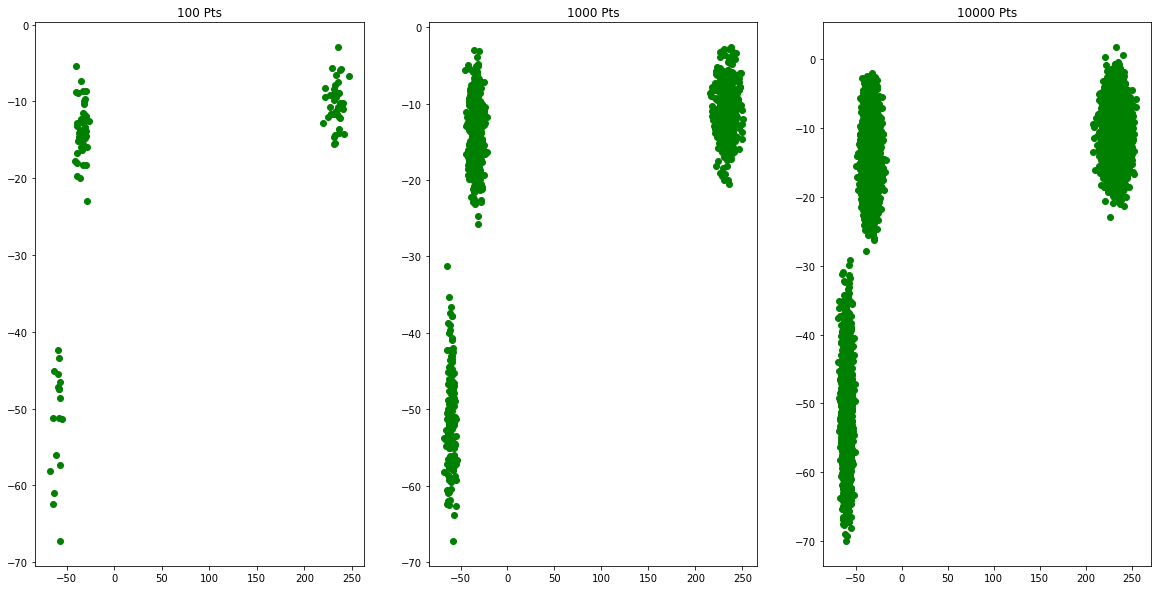

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.plot(training_data['A'].head(100), training_data['B'].head(100), "go")
plt.title("100 Pts")

plt.subplot(1,3,2)
plt.plot(training_data['A'].head(1000), training_data['B'].head(1000), "go")
plt.title("1000 Pts")

plt.subplot(1,3,3)
plt.plot(training_data['A'].head(10000), training_data['B'].head(10000), "go")
plt.title("10000 Pts")
plt.show()

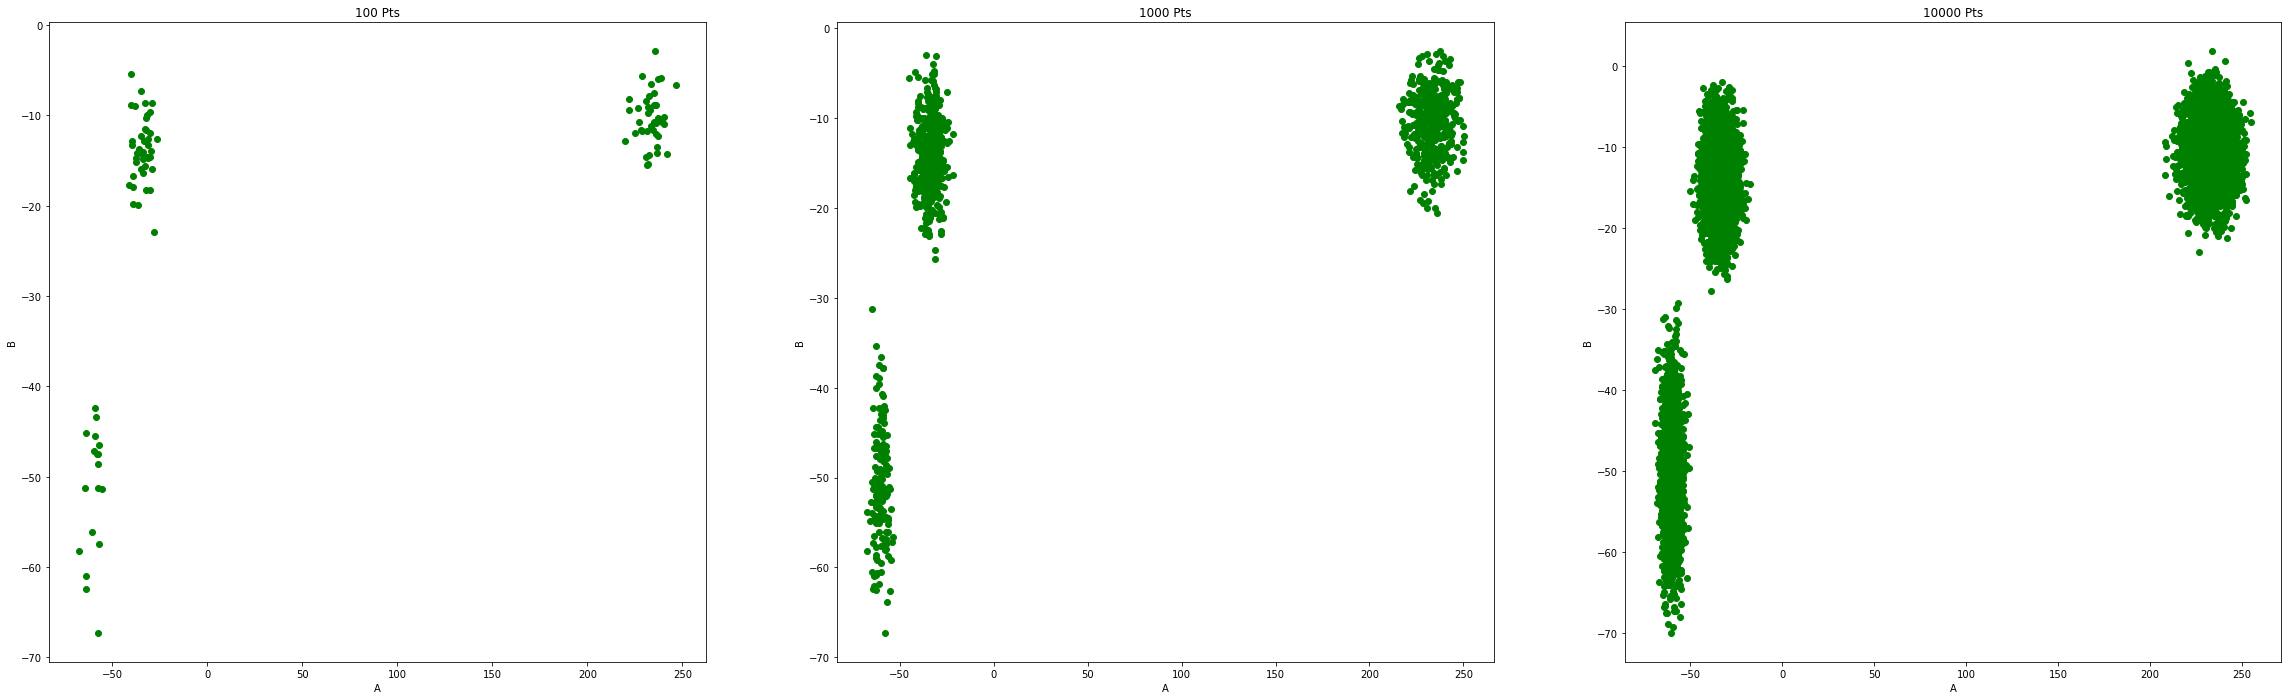

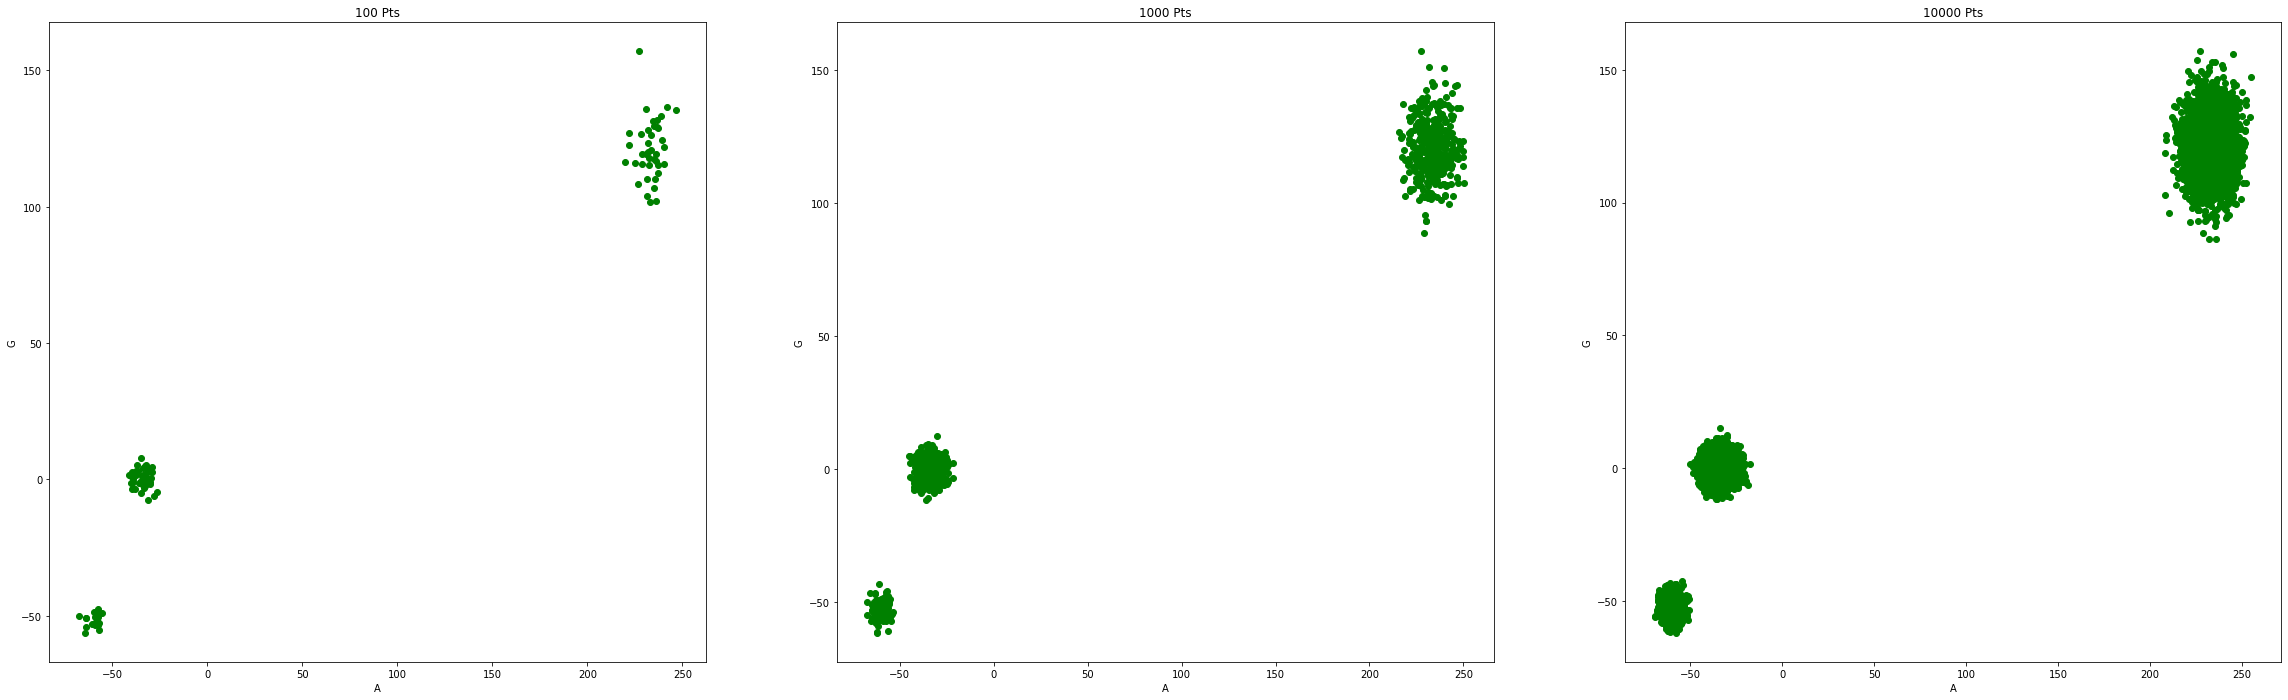

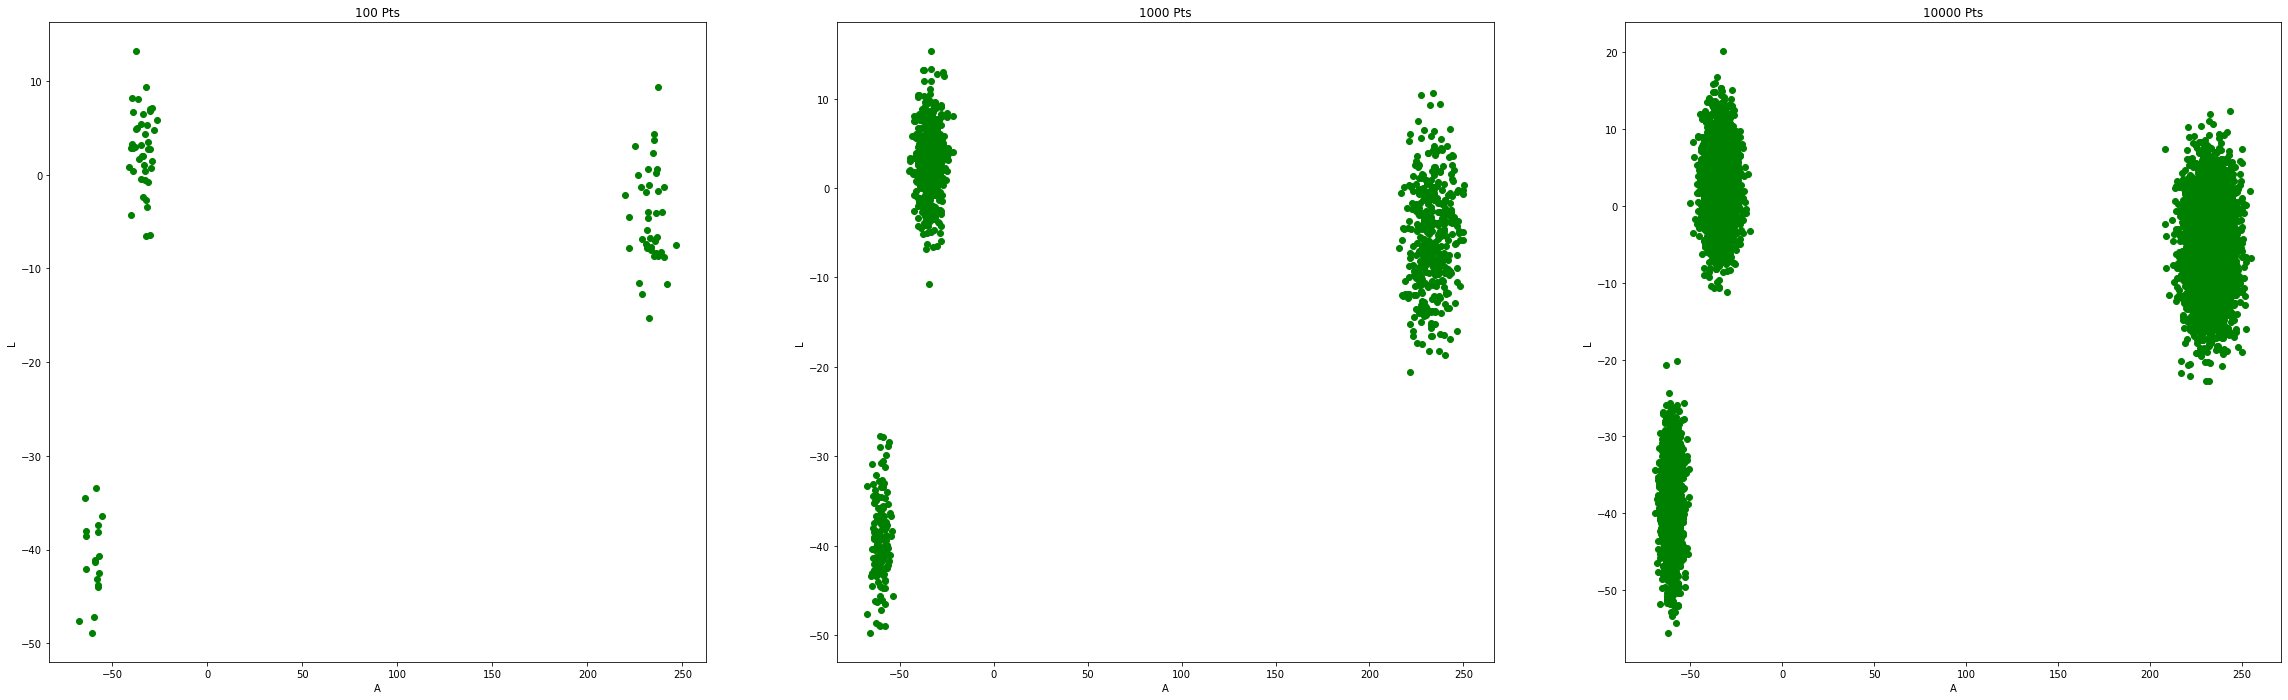

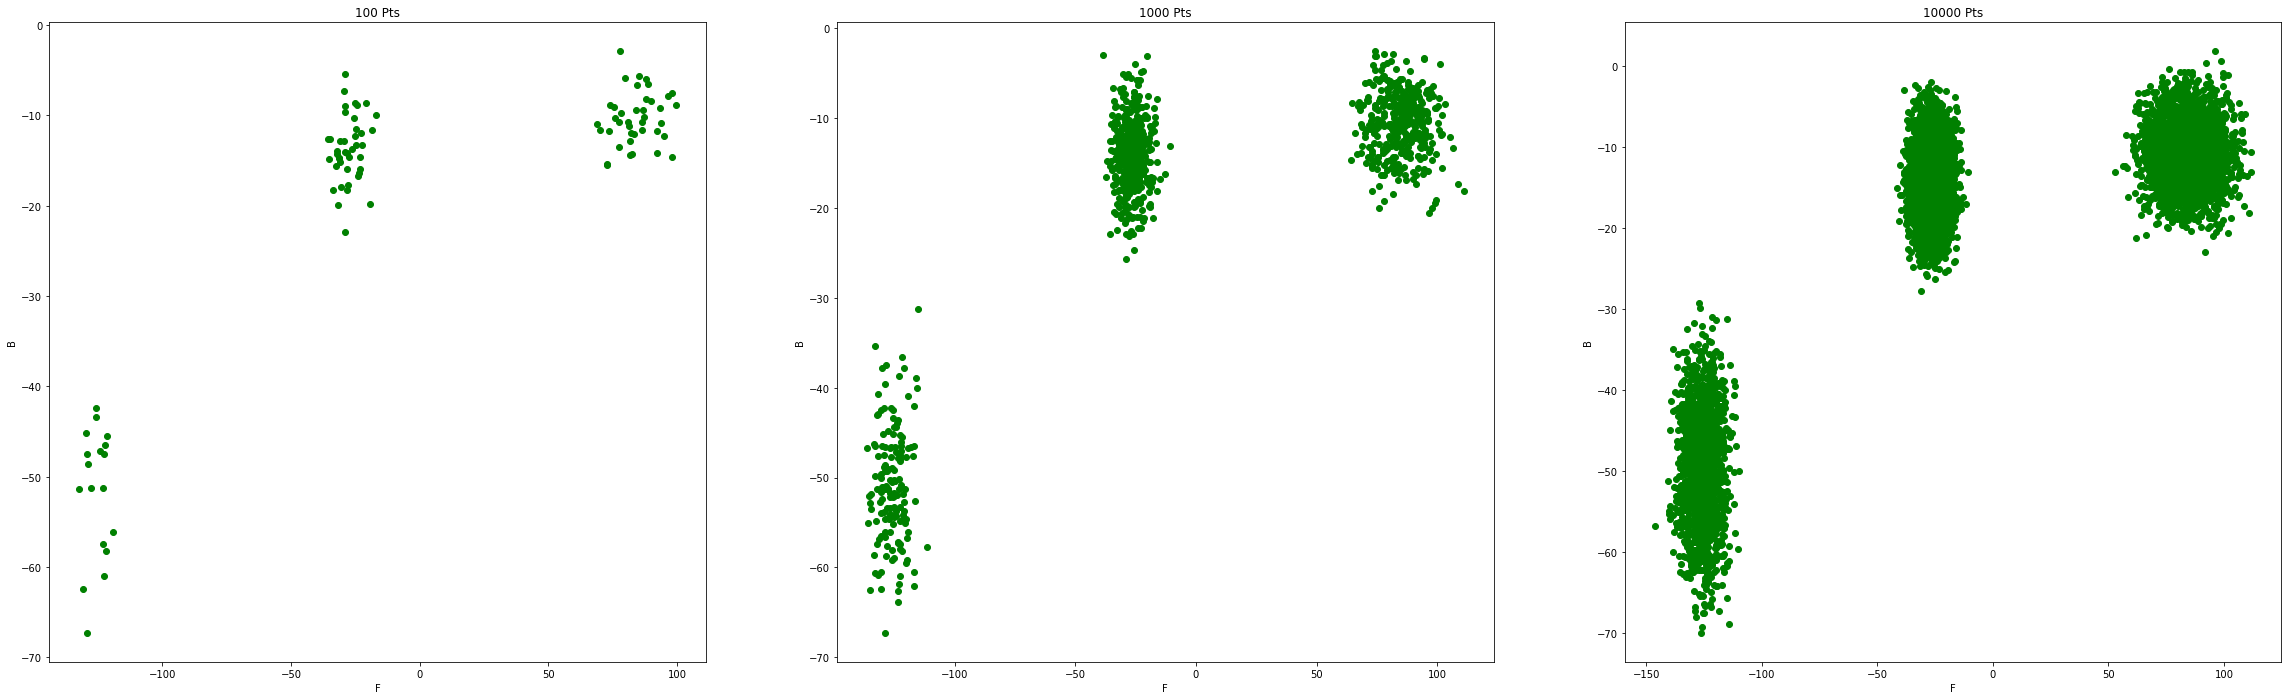

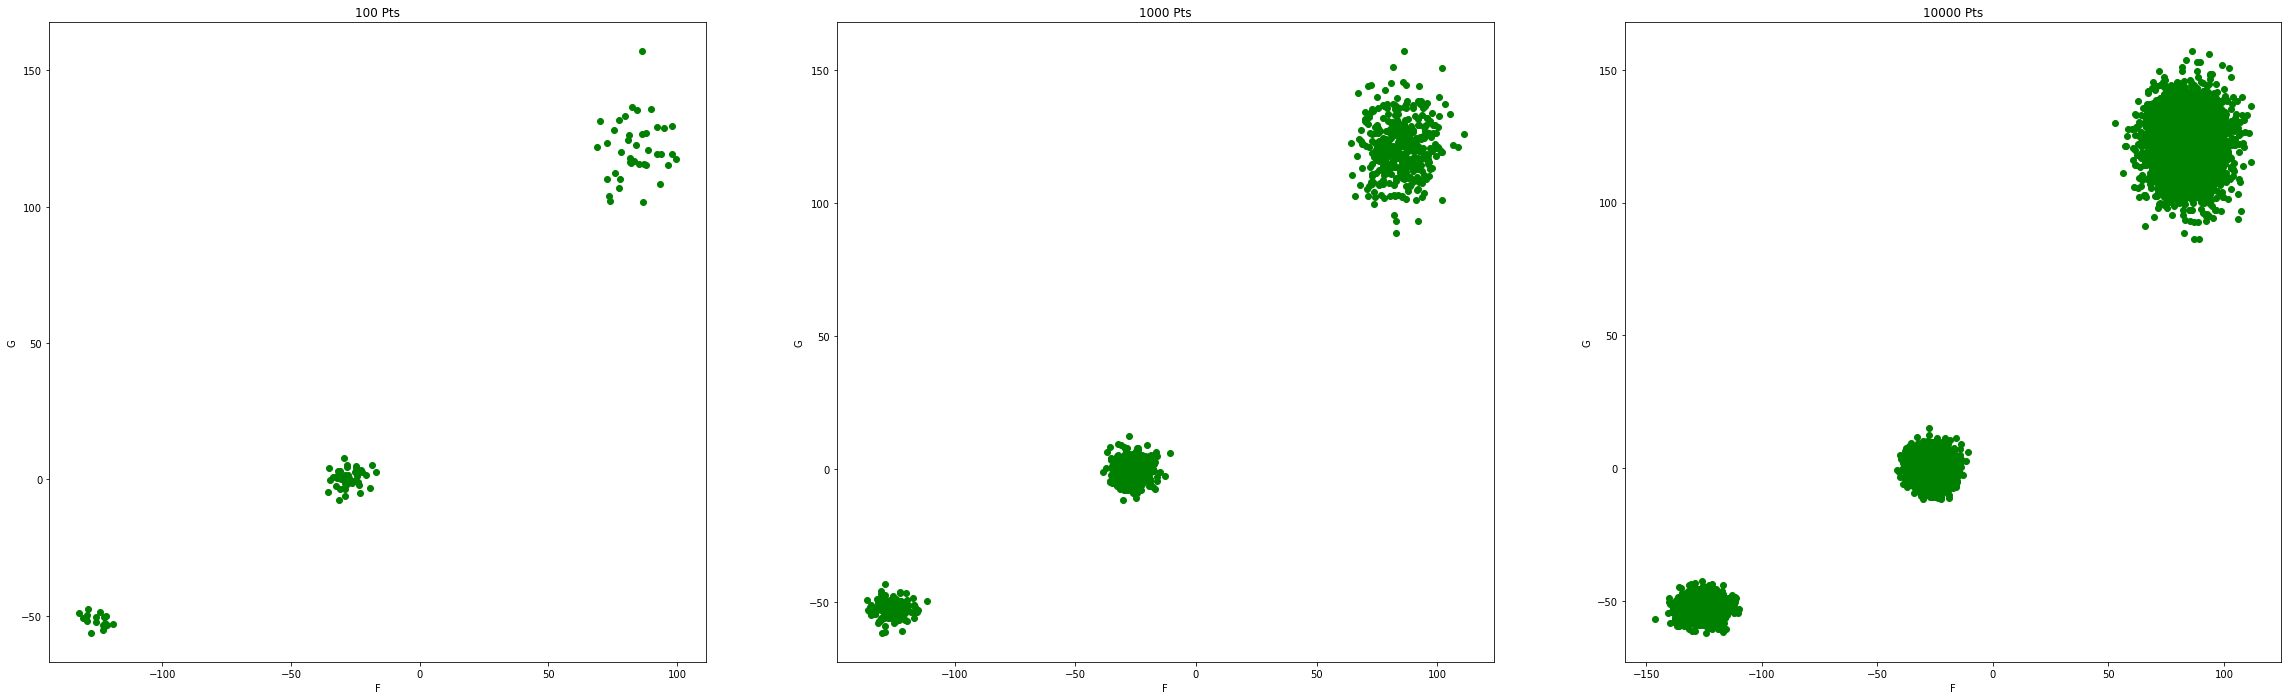

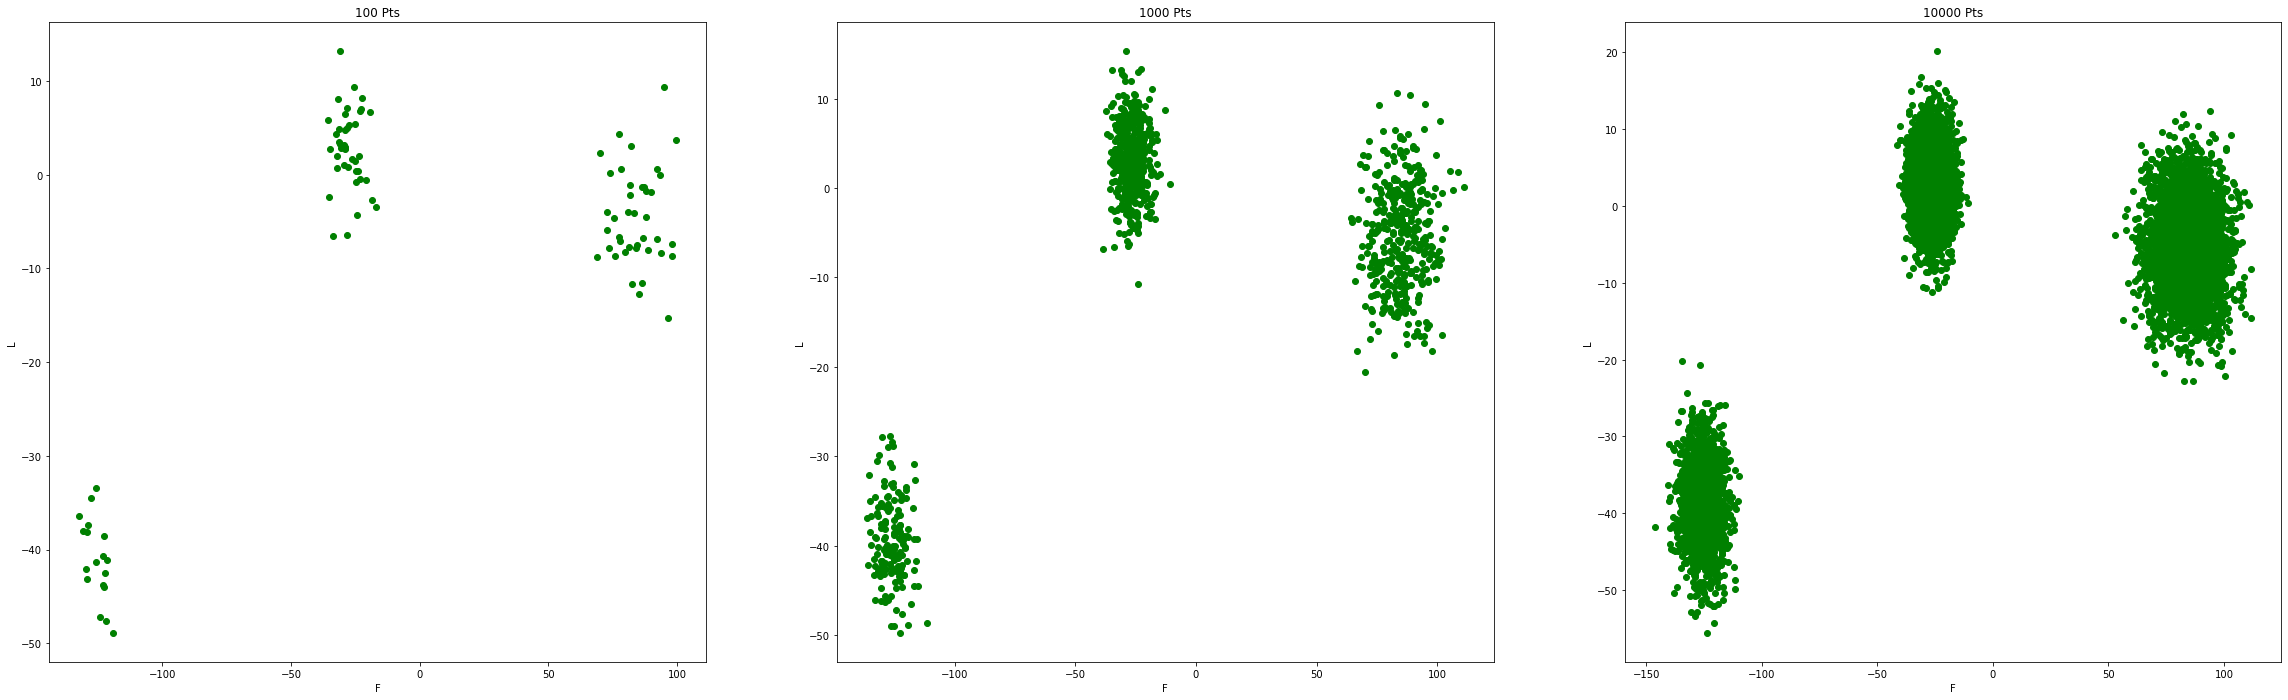

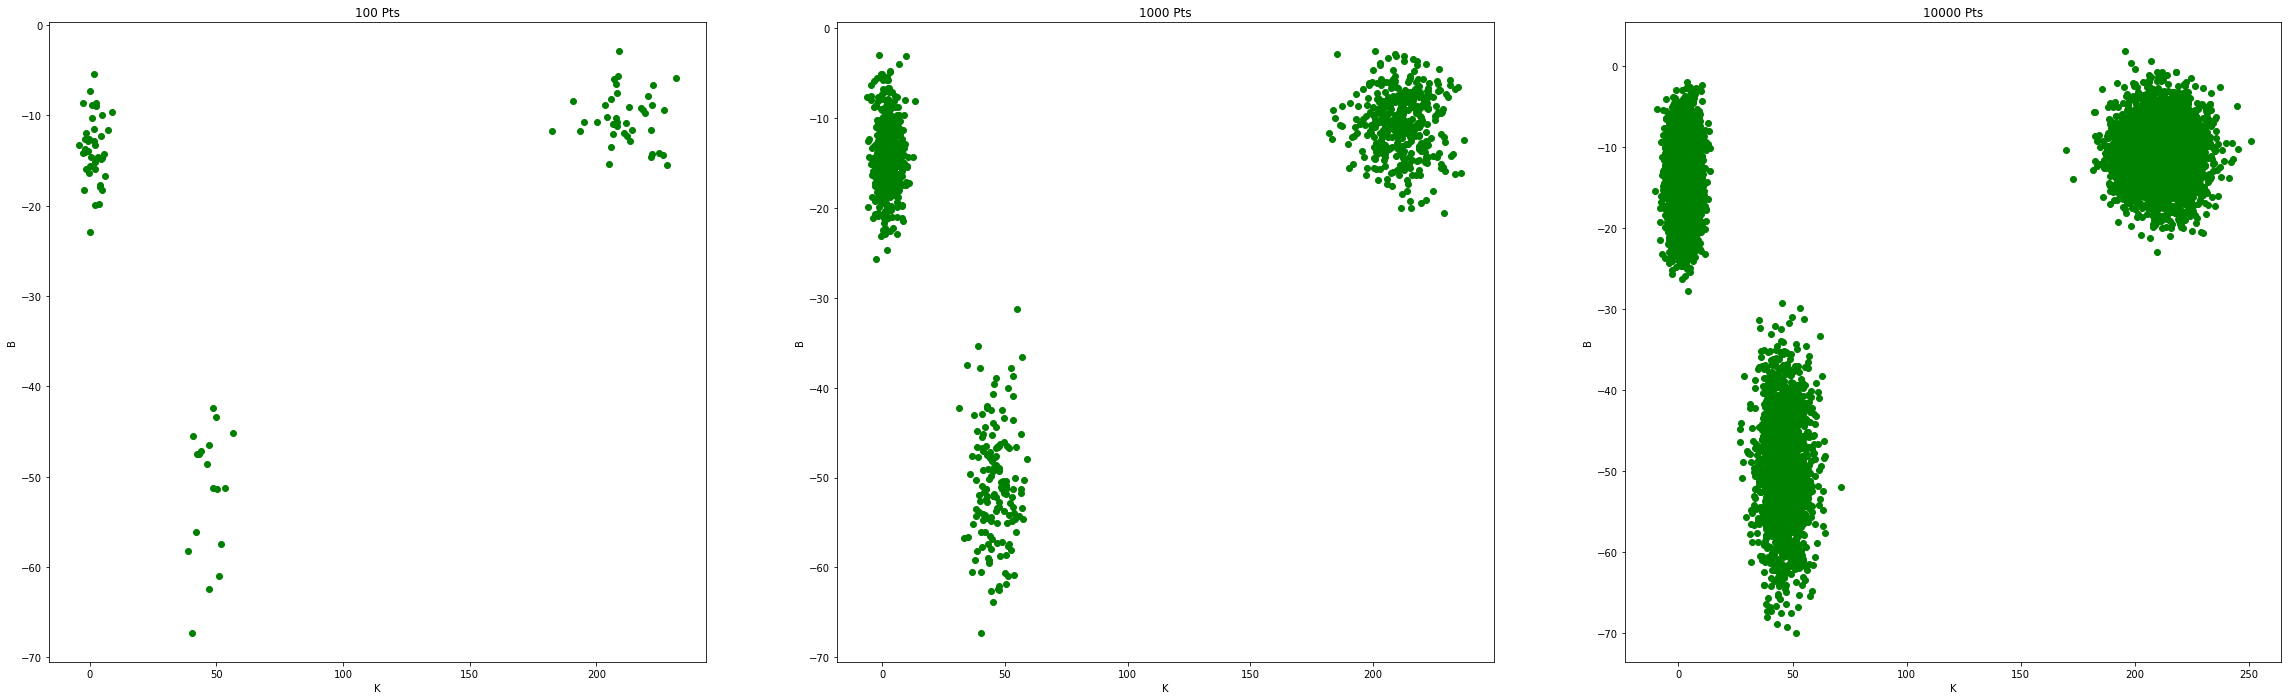

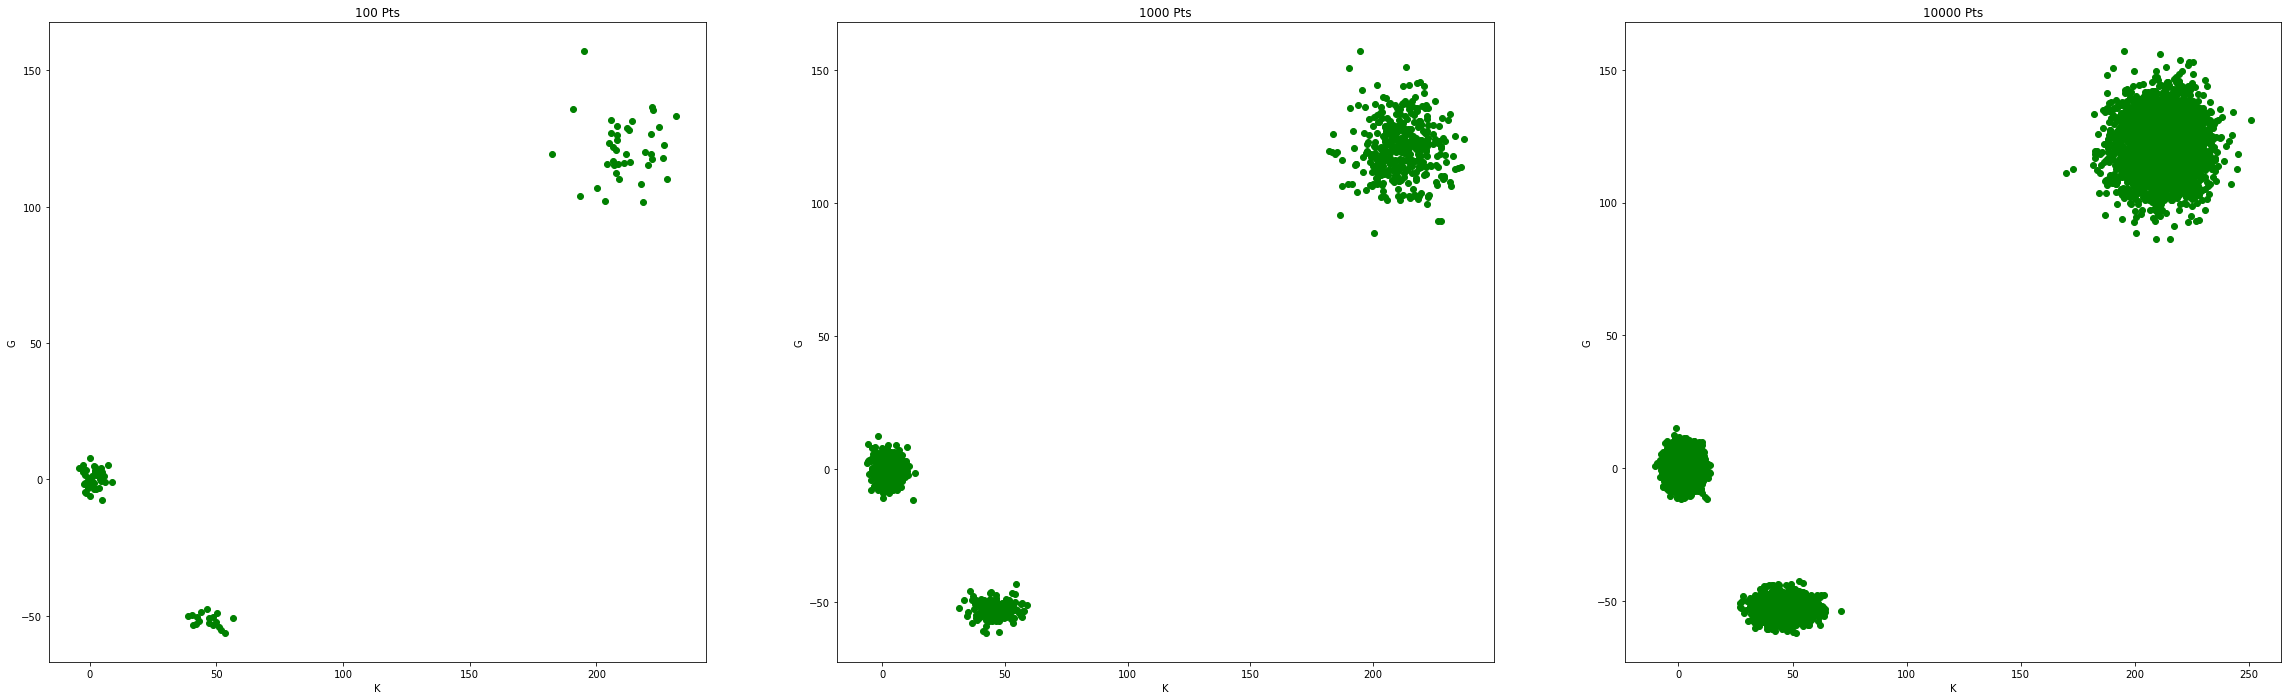

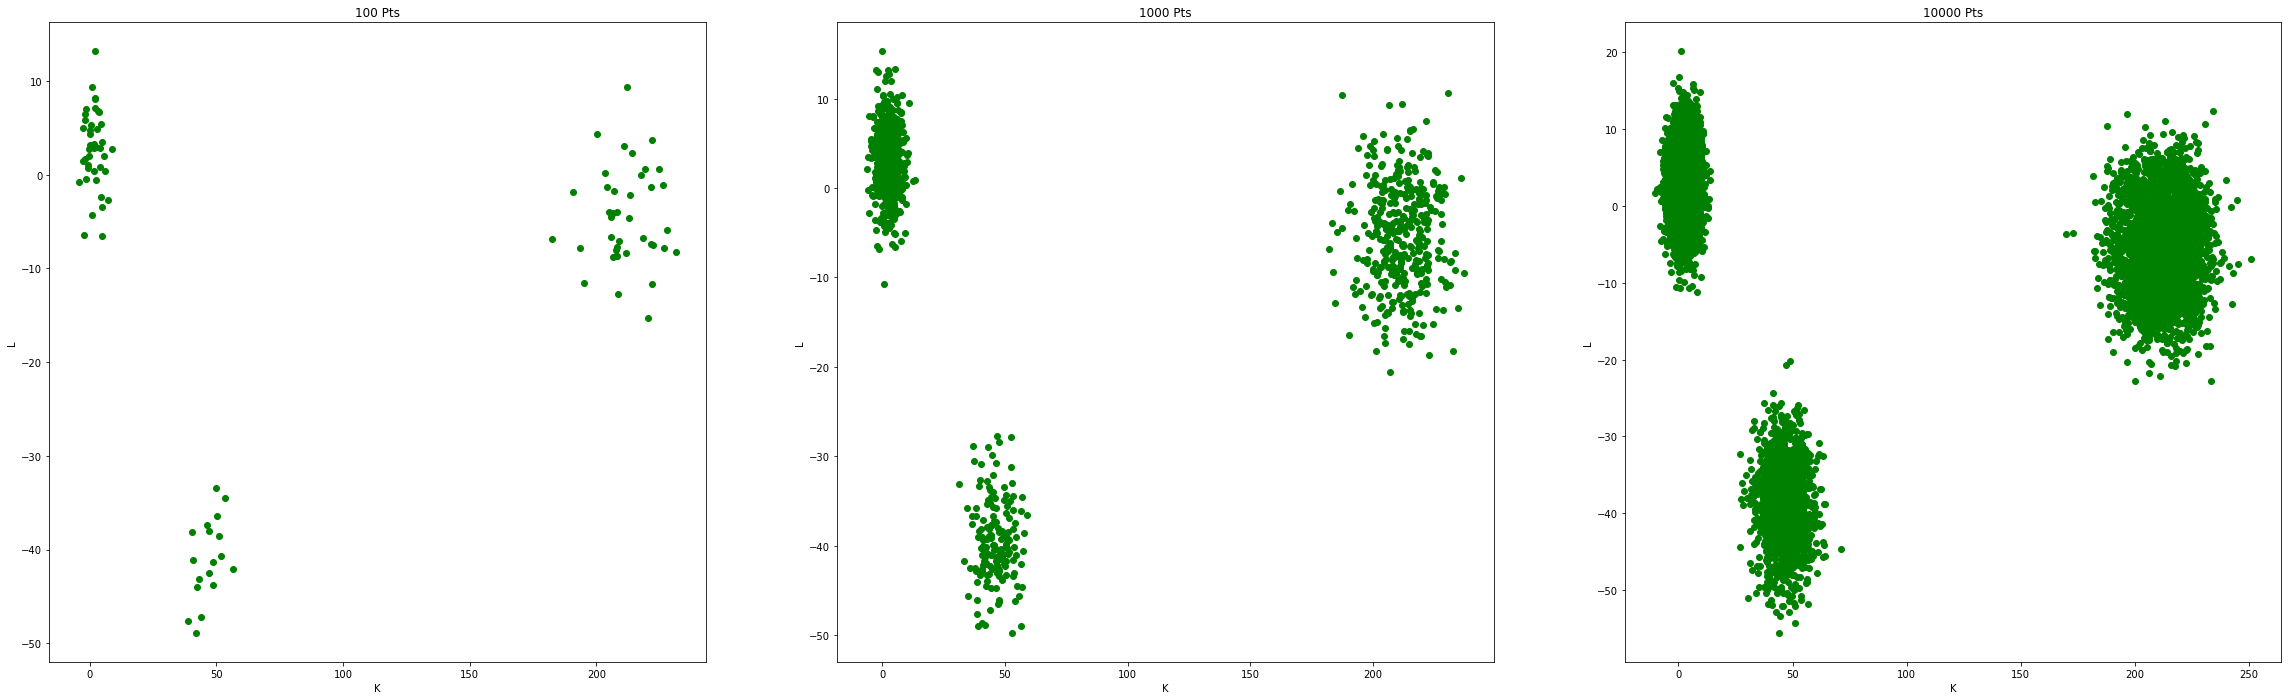

In [26]:
features = training_data.columns[:-1]

for i in range(0, len(features), 5):
    for j in range(1, len(features), 5):
        if i != j:
            plt.figure(figsize=(40, 40))
            plt.subplot(3,3,1)
            plt.plot(training_data[features[i]].head(100), training_data[features[j]].head(100), "go")
            plt.xlabel(features[i])
            plt.ylabel(features[j])
            plt.title("100 Pts")

            plt.subplot(3,3,2)
            plt.plot(training_data[features[i]].head(1000), training_data[features[j]].head(1000), "go")
            plt.xlabel(features[i])
            plt.ylabel(features[j])
            plt.title("1000 Pts")
            
            plt.subplot(3,3,3)
            plt.plot(training_data[features[i]].head(10000), training_data[features[j]].head(10000), "go")
            plt.xlabel(features[i])
            plt.ylabel(features[j])
            plt.title("10000 Pts")
            plt.show()

In [22]:
K = range(1,10)
Sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

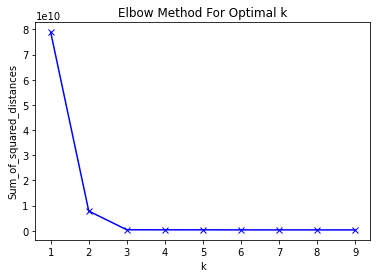

In [23]:
# A plot to display what the optimal K will be
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [24]:
pipelineK0=PMMLPipeline([('mapper',DataFrameMapper([(X_train.columns.values,
                                                       [StandardScaler()])])),
                        ('pca',PCA(n_components=2)),
                        ('cluster',KMeans(n_clusters=3))])
pipelineK0.fit(training_data,training_data['Class'])
results=pipelineK0.predict(X_test)
actual=np.concatenate(y_test.values)
print('Accuracy:', metrics.accuracy_score(actual,results))
print("Homogeneity_score:", metrics.homogeneity_score(actual, results))

Accuracy: 0.16651666666666667
Homogeneity_score: 6.763948820205992e-06
